### Autoencoder with Convolutional Neural Network

In this notebook, I will experiment with the implementation of an autoencoder for augmentation of the histopathology dataset. The augmented data is used to train a CNN network to see if it performs better than a baseline CNN model trained on the normal dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Input, MaxPool2D, UpSampling2D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

The PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within the function `get_pcam_generators` that returns them as output arguments. This function will later be called from the main code body. The class `model_transform` is used to set the correct preprocessing function for the data generators.


In [32]:
# Written by Constantijn
class model_transform:
     def __init__(self, ae_model_1):
          self.ae_model_1 = ae_model_1

     def model_transform(self, tensor):
          tensor_adjusted = utils.img_to_array(tensor)
          tensor_adjusted = np.array([tensor_adjusted])
          tensor_adjusted_prediction = self.ae_model_1.predict(tensor_adjusted/255, verbose=None)[0]
          return tensor_adjusted_prediction*255


def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32, class_mode='binary', prep_function=None):
     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255

     # instantiate data generators
     if prep_function is not None:
          datagen = ImageDataGenerator(rescale=RESCALING_FACTOR, preprocessing_function=prep_function)
     else:
          datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode=class_mode)


     val_gen = datagen.flow_from_directory(VALID_PATH,
                                           target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                           batch_size=val_batch_size,
                                           class_mode=class_mode)
     
     return train_gen, val_gen

Now, the function `get_pcam_generators` that defines the data generators can be called from the main code body. Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [3]:
# Class mode "Input" for training autoencoder (unsupervised learning)
train_gen, val_gen = get_pcam_generators('../data', train_batch_size=16, val_batch_size=16, class_mode='input')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Building an autoencoder model

The autoencoder neural network model is defined within a class. Organizing the code into classes instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. For example, we can use the `get_pcam_generators` function to create data generators with different batch sizes just by calling the function with a different set of parameters. Or, we can use the `autoencoder` class to generate networks with different number of feature maps (see below). 

In [4]:
# Class structure from Constantijn & Nino implemented for AE model from Mart
class autoencoder(Sequential):
    def __init__(self, kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16):
        super().__init__()
        self.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.first_filters = first_filters
        self.second_filters = second_filters

    def create_autoencoder(self):
        # Encoder
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(self.pool_size, padding='same'))
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(self.pool_size, padding='same'))

        # Decoder
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(UpSampling2D(self.pool_size))
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(UpSampling2D(self.pool_size))
        self.add(Conv2D(3, self.kernel_size, activation='sigmoid', padding='same'))

    def compile_model(self):
        self.compile(Adam(learning_rate=0.001), loss='mean_squared_error')
    
model_ae = autoencoder()
model_ae.create_autoencoder()
model_ae.compile_model()
model_ae._name = 'autoencoder'

If you want to know the shapes of the outputs of all layers in the network (the dimensionality of the feature maps), you can print them in the following way:

In [5]:
model_ae.summary();

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 up_sampling2d (UpSampling2  (None, 48, 48, 16)        

### Training and evaluating the autoencoder model

Finally, the model can be trained using data generated by the data generators and then evaluated. This is done in a similar way to the previous assignment. Furthermore, in addition to the Tensorflow callback, an additional callback that saves the "best" version of the trained model to a file is added, and the model structure is saved to a json file. This enables loading the model and corresponding weights at a later time point (e.g. when we want to evaluate the model on a test set). 

In [6]:
# Save the model and weights
model_name = 'autoencoder'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_ae.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen.n//train_gen.batch_size//4
val_steps = val_gen.n//val_gen.batch_size//4

history = model_ae.fit(train_gen, steps_per_epoch=train_steps, 
                       validation_data=val_gen,
                       validation_steps=val_steps,
                       epochs=3,
                       callbacks=callbacks_list)

Epoch 1/3
2250/2250 [==============================] - ETA: 0s - loss: 0.0148
Epoch 1: val_loss improved from inf to 0.01178, saving model to autoencoder_weights.hdf5
2250/2250 [==============================] - 508s 225ms/step - loss: 0.0148 - val_loss: 0.0118
Epoch 2/3


c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2250/2250 [==============================] - ETA: 0s - loss: 0.0111
Epoch 2: val_loss improved from 0.01178 to 0.01096, saving model to autoencoder_weights.hdf5
2250/2250 [==============================] - 432s 192ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 3/3
2250/2250 [==============================] - ETA: 0s - loss: 0.0101
Epoch 3: val_loss improved from 0.01096 to 0.01002, saving model to autoencoder_weights.hdf5
2250/2250 [==============================] - 420s 186ms/step - loss: 0.0101 - val_loss: 0.0100


Lets visualize the output of the trained CAE model. The output of the CAE model is used as augmented dataset in the upcoming steps.

1/1 [==============================] - 0s 122ms/step


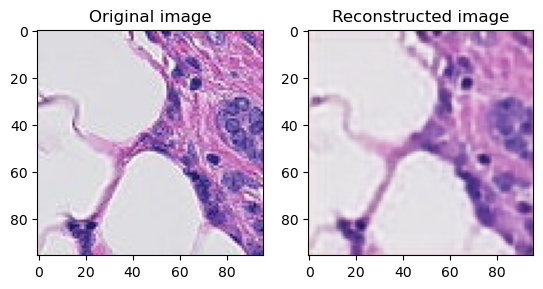

In [7]:
# Produce a prediction on the validation set
img_batch = train_gen[0][1] # [batch][class][image_nr]
predict_test = model_ae.predict(img_batch) 
image_nr = 1

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_batch[image_nr])
ax[0].set_title('Original image')
ax[1].imshow(predict_test[image_nr])
ax[1].set_title('Reconstructed image');

### Building a CNN with CAE preprocessing function

Before creating the CNN model, the data generators are reconstructed with a binary class mode. The generators for the augmented data are initialized with the CAE model as preprocessing function. The CNN model is also defined within a class. 

In [33]:
# Constructing the data generators for the normal dataset and the augmented dataset
train_gen_cnn, val_gen_cnn = get_pcam_generators('../data', class_mode='binary')    
train_gen_cnn_aug, val_gen_cnn_aug = get_pcam_generators('../data', class_mode='binary', prep_function=model_transform(model_ae).model_transform)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [9]:
class cnn(Sequential):
    def __init__(self, kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64):
        super().__init__()
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.first_filters = first_filters
        self.second_filters = second_filters

    def create_cnn(self):
        self.add(Conv2D(self.first_filters, self.kernel_size, activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
        self.add(MaxPool2D(pool_size=self.pool_size))
        self.add(Conv2D(self.second_filters, self.kernel_size, activation='relu', padding='same'))
        self.add(MaxPool2D(pool_size=self.pool_size))

        # layers replacing the dense layers
        self.add(Conv2D(self.second_filters, (6,6), activation='relu', padding='valid'))
        self.add(Conv2D(1, (1,1), activation='sigmoid', padding='same'))
        self.add(GlobalAveragePooling2D())

    def compile_model(self):
        self.compile(SGD(learning_rate=0.01, momentum=0.95), loss = 'binary_crossentropy', metrics=['accuracy'])
    
model_cnn = cnn()
model_cnn.create_cnn()
model_cnn.compile_model()
model_cnn._name = 'cnn'

Lets look at the shapes of the outputs of all layers in the network (the dimensionality of the feature maps).

In [10]:
model_cnn.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 64)          147520    
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 1)           65      

### Training and evaluating the CNN models

The baseline model can be trained using the data generators and then evaluated. Furthermore, a similar transfer learning CNN will be trained on the augmented dataset to see the difference in performance.

In [18]:
# Save the model and weights
model_name = 'cnn'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_cnn.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_cnn.n//train_gen_cnn.batch_size
val_steps = val_gen_cnn.n//val_gen_cnn.batch_size

history = model_cnn.fit(train_gen_cnn, steps_per_epoch=train_steps,
                        validation_data=val_gen_cnn,
                        validation_steps=val_steps,
                        epochs=3,
                        callbacks=callbacks_list)

Epoch 1/3
4500/4500 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8121
Epoch 1: val_loss improved from inf to 0.37898, saving model to cnn_weights.hdf5
4500/4500 [==============================] - 1304s 290ms/step - loss: 0.4138 - accuracy: 0.8121 - val_loss: 0.3790 - val_accuracy: 0.8354
Epoch 2/3


c:\Users\20212077\.conda\envs\8p361\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4500/4500 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8419
Epoch 2: val_loss improved from 0.37898 to 0.35729, saving model to cnn_weights.hdf5
4500/4500 [==============================] - 1221s 271ms/step - loss: 0.3607 - accuracy: 0.8419 - val_loss: 0.3573 - val_accuracy: 0.8430
Epoch 3/3
4500/4500 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8556
Epoch 3: val_loss improved from 0.35729 to 0.31666, saving model to cnn_weights.hdf5
4500/4500 [==============================] - 1266s 281ms/step - loss: 0.3365 - accuracy: 0.8556 - val_loss: 0.3167 - val_accuracy: 0.8633


500/500 [==============================] - 42s 84ms/step


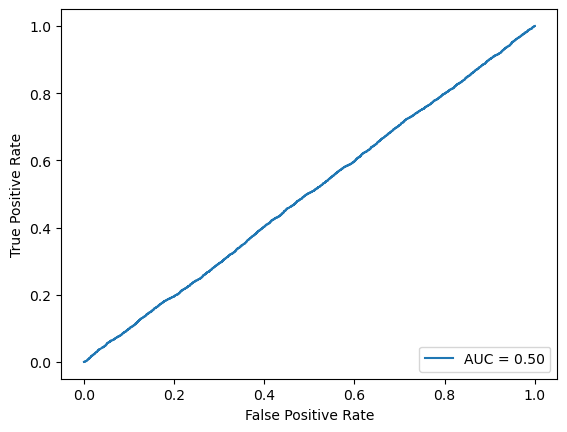

In [34]:
# Getting labels and predictions on validation set
val_true = val_gen_cnn.classes
val_probs = model_cnn.predict(val_gen_cnn, steps=val_steps)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot();

Lets now train a similar CNN using the augmented dataset. We will do this by entering the autoencoder model as a preprocessing function in the data generators. This is already done a few code blocks earlier. A new instance of the `cnn` class is created for this new model.

In [20]:
model_cnn_aug = cnn()
model_cnn_aug.create_cnn()
model_cnn_aug.compile_model()
model_cnn_aug._name = 'cnn_aug'

model_cnn_aug.summary()

Model: "cnn_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 64)          147520    
                                                                 
 conv2d_12 (Conv2D)          (None, 1, 1, 1)           65  

In [ ]:
# Save the model and weights
model_name = 'cnn_aug'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model_cnn_aug.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json)

# Define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_cnn_aug.n//train_gen_cnn_aug.batch_size
val_steps = val_gen_cnn_aug.n//val_gen_cnn_aug.batch_size

history = model_cnn_aug.fit(train_gen_cnn_aug, steps_per_epoch=train_steps,
                            validation_data=val_gen_cnn_aug,
                            validation_steps=val_steps,
                            epochs=3,
                            callbacks=callbacks_list)

In [ ]:
# Getting labels and predictions on validation set
val_true = val_gen_cnn_aug.classes
val_probs = model_cnn_aug.predict(val_gen_cnn_aug, steps=val_steps)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot()